In [1]:
import ipywidgets as widgets
import netCDF4
import sys
import time
import scipy as sp
import landlab
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, FastscapeEroder, SinkFillerBarnes, FlowDirectorD8, ChannelProfiler, TrickleDownProfiler
from landlab.components.flow_accum.flow_accum_bw import find_drainage_area_and_discharge
from landlab import imshow_grid
from landlab.utils import get_watershed_mask,get_watershed_outlet,get_watershed_nodes

nb_output = sys.stdout # Location to write to console not the notebook
console_output = open('/dev/stdout', 'w') # Location to write to console
#?sp.optimize.minimize

In [ ]:
#loading topography in for first time:
#if returning to notebook, start in cell 4
zr_nc=netCDF4.Dataset('../DATA/Clyde_Topo_100m_working.nc')
zr_ma = zr_nc['z'][:,:]
plt.imshow(zr_ma, origin='lower')
mg = RasterModelGrid(zr_ma.shape,xy_spacing=(100,100))

#landmask_nc=netCDF4.Dataset('input_dir/landmask.nc')
#landmask = landmask_nc['z'][:,:].data.astype(float)

zr = mg.add_zeros('node', 'topographic__elevation')
zr += np.reshape(zr_ma.data.astype(float),zr.shape)
dx = 100

# Set up the boundary conditions on the square grid
mg.set_fixed_value_boundaries_at_grid_edges(True,True,True,True)

flat_shape = zr.shape # a tuple to flatten arrays [number of nodes long]
full_shape = mg.shape # the full shape of the grid [rows, columns]


In [ ]:
#sink filling algorithm: only needs to be run once, otherwise load saved elevationfrom cell below
sfb = SinkFillerBarnes(mg, method='D8',fill_flat=False)
sfb.run_one_step()

#extract data from mg to numpy array (at node)
elevation = mg.field_values('node', 'topographic__elevation')
elevation = elevation.reshape(mg.shape)
np.save('filled_topography.npy', elevation)


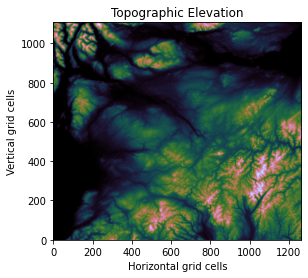

In [2]:
#start here, if returning to notebook after filling algorithm has been run before

zr_nc=netCDF4.Dataset('../DATA/Clyde_Topo_100m_working.nc')
zr_ma = zr_nc['z'][:,:]
#save array as filled_topo.npy
topography = np.load('filled_topography.npy')
#add array as topography field
mg = RasterModelGrid(zr_ma.shape,xy_spacing=(100,100))

#landmask_nc=netCDF4.Dataset('input_dir/landmask.nc')
#landmask = landmask_nc['z'][:,:].data.astype(float)

zr = mg.add_field('node', 'topographic__elevation', topography)
dx = 100

flat_shape = zr.shape # a tuple to flatten arrays [number of nodes long]
full_shape = mg.shape # the full shape of the grid [rows, columns]

# Set up the boundary conditions on the square grid
mg.set_fixed_value_boundaries_at_grid_edges(True,True,True,True)
plt.figure()
plt.title("Topographic Elevation")

plt.imshow(zr.reshape(full_shape),cmap='cubehelix',origin='lower') 
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.show()



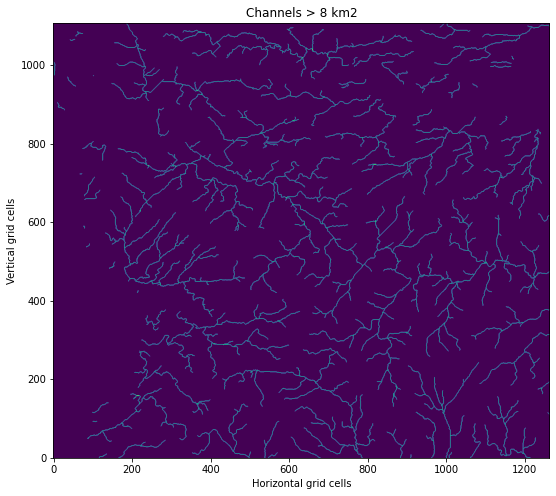

In [3]:
# instantiate the flow routing:

frr = FlowAccumulator(
    mg,
    'topographic__elevation',
    flow_director = 'FlowDirectorD8')
frr.run_one_step()  # flow routing

zrold = zr[mg.nodes] # pre-incision elevations

# instantiate the stream power law
k=3.62
m=0.35
n=1
spr = FastscapeEroder(mg, K_sp=k, m_sp=m, n_sp=n)

dt=0.1# Timestep in Ma
spr.run_one_step(dt)    # erosion: stream power
zrnew = zr[mg.nodes]    # post-incision elevations
incise = zrold - zrnew  # incision per cell
cell_area = mg.dx * mg.dy
qs = incise*cell_area # Volume sediment produced per cell
qsflat = qs.ravel()     # flatten qs for flow routing calculation

a,q = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node'],runoff = qsflat) 
# q is cumulative flux for SPL model
a, q_homo_incis = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node']) # a is number of nodes
# q is cumulative flux for homogeneous incision

area = mg.at_node['drainage_area']
np.amax(area)
area_threshold = 8 #float(sys.argv[1]) #25 km2
is_drainage = area > (area_threshold*1000000) #km2 to m2
mg.add_field('node','channels',is_drainage,clobber=True)


plt.rcParams["figure.figsize"] = (12,8)
plt.figure()
plt.imshow(is_drainage.reshape(full_shape),origin='lower') 
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')

plt.title("Channels > 8 km2")
plt.show()


In [4]:
 
sample_data = np.loadtxt('../DATA/filtered_sample_loc.dat',dtype=str) # [x, y, sample #]
sample_locs = sample_data[:,0:2].astype(float)
channel_xy = np.flip(np.transpose(np.where(is_drainage.reshape(mg.shape))),axis=1)*100 # xy coordinates of channels
nudge = np.zeros(sample_locs.shape) # initiate nudge array

#nudging locations:
nudge[17] = [0,-200]    #nudging loc 632137 to S
nudge[34] = [-700,0]    #nudging loc 632164 to W
nudge[38] = [0,-400]    #nudging loc  632170 to S
nudge[39] = [-100,0]    #nudging loc 632171 to W
nudge[56] = [0,100]     #nudging loc 632197 to N
nudge[16] = [-300,-100] #nudging loc 632136 to SW
nudge[4 ] = [-300,-100] #nudging loc 632109 to SW
nudge[50] = [0,-100]    #nudging loc 632189 to S
nudge[3 ] = [-200,-100] #nudging loc 632108 to SW
#nudge[64] = [0,100]     #nudging loc 700012 to N
#nudge[69] = [100, -100] #nudging loc 700022 to SE



nudged_locs = sample_locs + nudge # Apply the nudges
# Fit the data to the nearest channel node
fitted_locs = np.zeros(sample_locs.shape) # Initialise snapped locality array
for i in np.arange(nudged_locs.shape[0]):
    sample = nudged_locs[i,:]
    diffs = channel_xy-sample
    distances = np.linalg.norm(diffs,axis=1)
    shortest = np.amin(distances)
    fitted_locs[i,:] = channel_xy[np.where(distances==shortest)]

Text(0.5, 1.0, 'Manual check of localities (you have to zoom in!)')

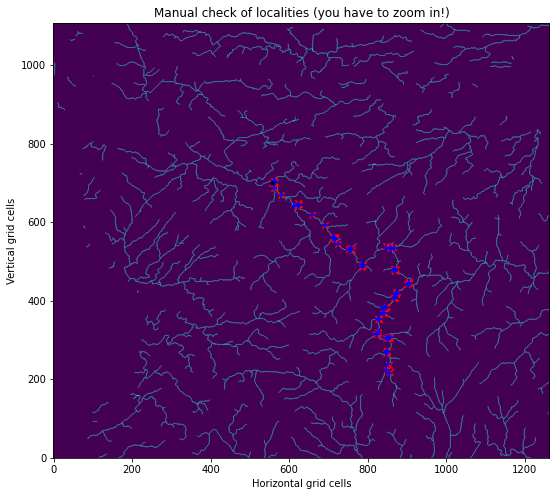

In [5]:
#%matplotlib notebook
dx=100
plt.figure()

plt.imshow(is_drainage.reshape(full_shape),origin='lower') 
#plt.scatter(x=channel_xy[:,0]/mg.dx, y=channel_xy[:,1]/mg.dx,c='grey', s=5)
plt.scatter(x=sample_locs[:,0]/mg.dx, y=sample_locs[:,1]/mg.dx, marker="x",c='r', s=40)
plt.scatter(x=fitted_locs[:,0]/mg.dx, y=fitted_locs[:,1]/mg.dx, marker="+",c='b', s=40)
plt.scatter(x=sample_locs[2,0]/mg.dx, y=sample_locs[2,1]/mg.dx, marker='.', c='k', s=40) #plotting point fursthest down stream
plt.scatter
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')
plt.title("Manual check of localities (you have to zoom in!)")

0.0
True


Text(0, 0.5, 'Vertical grid cells')

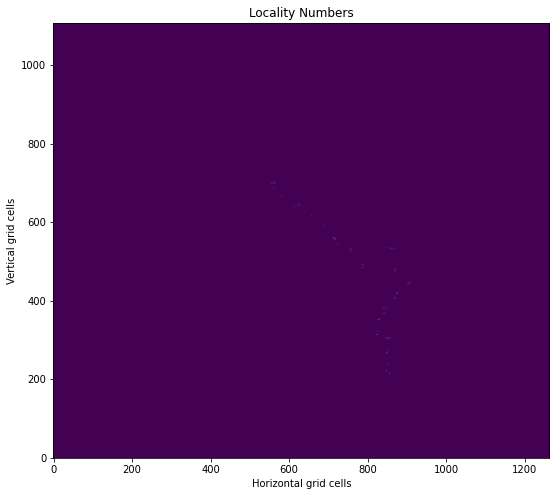

In [6]:
#%matplotlib notebook
loc_indxs = np.transpose(np.flip((fitted_locs/100).astype(int),axis=1))
print(np.sum(fitted_locs%100))
loc_nodes = np.ravel_multi_index(loc_indxs,dims=full_shape)

# Following statement should be true if all localities are correctly on model grid
print((is_drainage[loc_nodes]).all())

# loc_nodes is used to quick access data in the model grid at sample localities. 
# For example, we now access the *locality* number of every sample via the grid

locality_num_grid = np.zeros(flat_shape) - 20
locality_num_grid[loc_nodes] = sample_data[:,2].astype(float).astype(int)

mg.add_field('node','loc_nums',locality_num_grid,clobber=True) 

# Hovering cursor over each locality node will display the correct locality number
plt.figure()
plt.title("Locality Numbers")
plt.imshow(locality_num_grid.reshape(full_shape),origin='lower')
plt.xlabel('Horizontal grid cells')
plt.ylabel('Vertical grid cells')


In [7]:
print(sample_data[2,:])
print(fitted_locs[2])

['55659.1999284' '70021.6410317' '632104']
[ 55600.  69900.]


In [8]:
obs_data = pd.read_csv('../DATA/converted_chem_data.csv') #read in geochem data
elems =  obs_data.columns[1:].tolist() # List of element strings
obs_data[elems]=obs_data[elems].astype(float) # Cast numeric data to float


In [9]:
model_width = mg.shape[1] # number of x cells in topographic model grid
model_height = mg.shape[0] # number of y cells in topographic model grid
print(model_width, model_height)
def expand(block_grid,block_x,block_y):
    """Expands low res array of block heights into 
    model grid array that can be fed into topographic
    model. Note that blocks at the upper and eastern 
    perimeter are clipped if number of blocks doesn't 
    divide number of model cells. 
    
    block_x and block_y are the number of model cells 
    in each block in x and y dir respectively"""
    return(block_grid.repeat(block_y, axis=0).repeat(block_x, axis=1)[:model_height,:model_width])

1264 1108


[884092]
True
1873.42


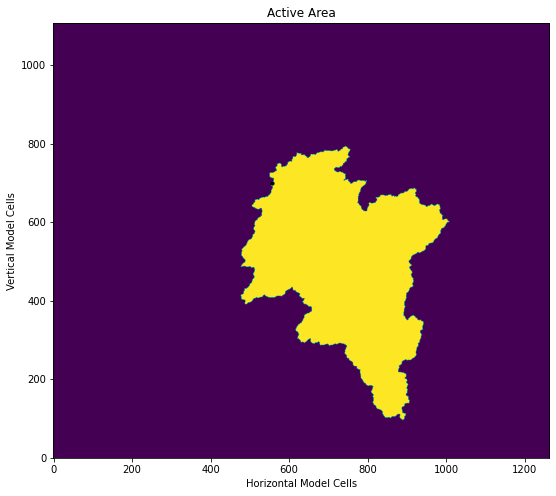

'\n#uncomment to test active area\nactive_blocks = get_active_blocks(10,10)\nplt.subplot(1,2,2)\nplt.imshow(active_blocks,origin=\'lower\')\nplt.title("Active Blocks")\nplt.xlabel("Horizontal Inversion Blocks")\nplt.ylabel("Vertical Inversion Blocks")\n'

In [10]:
lowest_sample = loc_nodes[sample_data[:,2]== '632104'] # Locality 632104
print(lowest_sample)
active_area = get_watershed_mask(mg,lowest_sample) # extract upstream area of most downstream tay sample 
print(True in active_area)
def get_active_blocks(nx,ny):
    """For a given number of blocks in the x 
    and y direction (nx & ny), returns a (ny,nx) 
    bool array saying if cell overlaps with active 
    area or not. """
    
    block_width = np.ceil(model_width/nx) 
    block_height = np.ceil(model_height/ny)

    model_grid_block_indices = np.zeros((model_height,model_width,2))    
    for i in np.arange(model_height):
        for j in np.arange(model_width):
            model_grid_block_indices[i,j,0] = i//block_height
            model_grid_block_indices[i,j,1] = j//block_width
    model_grid_block_indices = model_grid_block_indices.astype(int)        
    # 3D array that contains index of block that model cell corresponds to 
    # ([:,:,0] = y coordinate; [:,:,1] = x coordinate)
    
    out = np.zeros((ny,nx)).astype(bool)
    for i in np.arange(ny):
        for j in np.arange(nx):
            # Boolean array of model cells that correspond to block indeix (i,j)
            cells_in_block = np.logical_and(model_grid_block_indices[:,:,0] == i, model_grid_block_indices[:,:,1] == j)
            # Returns if block overlap with active area:
            out[i,j] = np.any(np.logical_and(cells_in_block,active_area.reshape(full_shape)))
    return(out)
print(np.sum(active_area)*((mg.dx/1000)**2)) #calculate total km2 of active area

#plt.subplot(1,2,1)
plt.imshow(active_area.reshape(full_shape),origin='lower')
plt.scatter(x=sample_locs[2,0]/mg.dx, y=sample_locs[2,1]/mg.dx, marker='.', c='k', s=40)
plt.title("Active Area")
plt.xlabel("Horizontal Model Cells")
plt.ylabel("Vertical Model Cells")
plt.show()

'''
#uncomment to test active area
active_blocks = get_active_blocks(10,10)
plt.subplot(1,2,2)
plt.imshow(active_blocks,origin='lower')
plt.title("Active Blocks")
plt.xlabel("Horizontal Inversion Blocks")
plt.ylabel("Vertical Inversion Blocks")
'''

In [12]:
obs_elems = obs_data[elems]
clyde_mth_comp = np.asarray(obs_elems[obs_data['SAMPLE_No'] == 632104])


prior_wtd_avg = pd.DataFrame(clyde_mth_comp)
prior_wtd_avg.columns = elems

prior_wtd_avg = np.mean(prior_wtd_avg,axis=0)
prior_wtd_avg_log = np.log(prior_wtd_avg)


In [ ]:
#takes long
#only need to run once, saves output as .npy file
unique_locs = np.unique(sample_data[:,2])
#print(unique_locs)

loc_areas = []
for loc_num in unique_locs:
    sample_node_num = loc_nodes[sample_data[:,2]==loc_num]
    if(sample_node_num.size==2): # Catch duplicate sample exception
        sample_node_num = sample_node_num[0]
    upst_area = get_watershed_mask(mg,sample_node_num)
    loc_areas = loc_areas + [upst_area]
loc_areas = np.array(loc_areas) # The full (not unique) upstream area for each sample site.

np.save('loc_areas.npy', loc_areas)


In [13]:
unique_locs = np.unique(sample_data[:,2])
loc_areas = np.load('loc_areas.npy')

In [14]:
def loc_to_area(loc):
    """Returns the catchment mask for a given locality"""
    return(loc_areas[np.where(unique_locs == loc)])

def b_is_nested_in_a(a,b):
    """Is catchment 'b' a nested subcatchment of catchment 'a'?"""
    return(not(np.any(np.invert(np.logical_or(a,np.invert(b))))))

def which_locs_are_contained_upstream_of(loc_a):
    """Which localities define subcatchments of area defined by loc 'a'"""
    loc_area = loc_to_area(loc_a)
    out_locs = []
    for loc_num in unique_locs:
        if(not(loc_num==loc_a)):
            upst_area = loc_to_area(loc_num)
            if(b_is_nested_in_a(loc_area,upst_area)):
                out_locs = out_locs + [loc_num]
    return(out_locs)

def find_unique_seg(loc):
    locs_upstream_of_ = which_locs_are_contained_upstream_of(loc)
    downstream_area = loc_to_area(loc)
    out = np.zeros(active_area.size).astype(bool)
    for upstream_loc in locs_upstream_of_:
        out = np.logical_or(out,loc_to_area(upstream_loc))
    unique_seg = np.logical_and(downstream_area,np.invert(out))
    return(unique_seg.reshape(active_area.shape))

In [15]:
def data_misfit(bdrck_arr,elem):
    """Returns L2norm data misfit for a given bedrock input array (mgkg), calculating predictions for given element assuming homogenous incision"""
    a, sed_comp = find_drainage_area_and_discharge(mg.at_node['flow__upstream_node_order'], mg.at_node['flow__receiver_node'],runoff = bdrck_arr)  # composition but homogeneous erosion
    sed_comp_norm = sed_comp/q_homo_incis
    l2norm = np.linalg.norm(np.log10(obs_data[elem]) - np.log10(sed_comp_norm[loc_nodes]))
    return(l2norm)   

In [16]:
def cost_roughness(blox,active_blox,block_x,block_y):
    """Returns l2 norm of roughness in both directions. 
    Assumes Von Neumann BCs dC/dx = dC/dy = 0"""
    copy = np.copy(blox)
    # Set von neumann BCs
    copy[np.invert(active_blox)] = 'nan' # set inactive nodes to 'nan'
    padded = np.pad(copy,pad_width=1,mode='constant',constant_values='nan') # pad with 'nan' too
    x_diffs = np.diff(padded,axis=1)/block_x # dC/dx
    y_diffs = np.diff(padded,axis=0)/block_y # dC/dy
    x_rough = np.sqrt(np.nansum(x_diffs**2)) # sqrt(SUM((dC/dx)^2)), NB 'nans' are treated as zeros using nansum.
    y_rough = np.sqrt(np.nansum(y_diffs**2)) # sqrt(SUM((dC/dy)^2))
    return(x_rough,y_rough) # return tuple of roughness along both axes


In [17]:
def smoothed_objective(param_arr,blox,active_blox,block_xstep,block_ystep,elem,lamda_):
    """Tests a given parameter array `param_arr` for the given inversion setup. 
    Returns the least squares damped cost. Each iteration is ~25 ms"""
    blox[active_blox] = param_arr # Update model grid with new parameters; 1.25 us
    bedrock = expand(np.exp(blox),block_xstep,block_ystep) # Convert log blocks into continuous grid in mg/kg; 3.5 ms
    data_sq = data_misfit(bedrock.reshape(flat_shape),elem)**2 # Calculate data misfit; 19.4 ms
    rough_x,rough_y = cost_roughness(blox,active_blox,block_xstep,block_ystep) # Calculate roughness; 68 us
    roughness_sq = (lamda_**2)*(rough_x**2 + rough_y**2) # Roughness squared; 0.6 us
    return(data_sq+roughness_sq)

In [18]:
def initiate_blocky_inversion_smart(nx,ny,elem):
    """Initiates an inversion grid for given number of 
    cells and element. """
    
    # Define full-res starting solution
    full_init = np.zeros(active_area.shape) + prior_wtd_avg_log[elem]  
    for loc_num in unique_locs:
        values = np.asarray(obs_elems[elem][obs_data['SAMPLE_No'] == float(loc_num)])
        if(values.size==2): # Catch duplicate sample exception
            full_init[find_unique_seg(loc_num)] = np.mean(np.log(values))
        else:
            full_init[find_unique_seg(loc_num)] = np.log(values)

    # Define inversion nodes
    blox = np.zeros((ny,nx))
    active_blox = get_active_blocks(nx,ny) # Active cells
    
    block_x_step = np.ceil(model_width/nx) # Block width
    block_y_step = np.ceil(model_height/ny) # Block height
    
    # Downsample initial guess
    model_grid_block_indices = np.zeros((model_height,model_width,2))
    for i in np.arange(model_height):
        for j in np.arange(model_width):
            model_grid_block_indices[i,j,0] = i//block_y_step
            model_grid_block_indices[i,j,1] = j//block_x_step
    model_grid_block_indices = model_grid_block_indices.astype(int)
    # 3D array that contains index of block that model cell corresponds to
    # ([:,:,0] = y coordinate; [:,:,1] = x coozzzrdinate)
     
    for i in np.arange(ny):
        for j in np.arange(nx):
            # Boolean array of model cells that correspond to block indeix (i,j)
            cells_in_block = np.logical_and(model_grid_block_indices[:,:,0] == i, model_grid_block_indices[:,:,1] == j)
            # Returns if block overlap with active area:
            blox[i,j] = np.mean(full_init.reshape(full_shape)[cells_in_block])
    blox[np.invert(active_blox)] =  prior_wtd_avg_log[elem]     
    return blox,active_blox,block_x_step,block_y_step

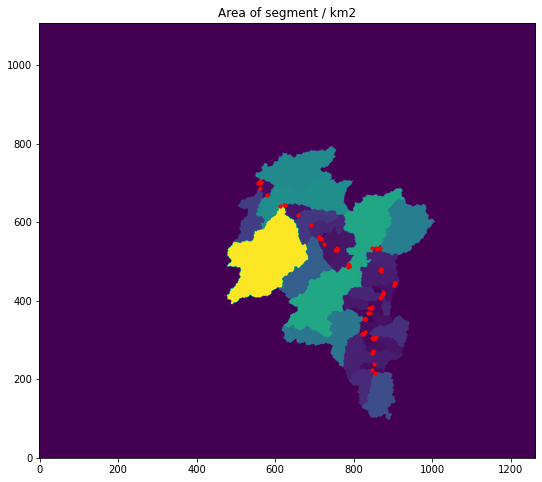

In [20]:
#Creating area per locality plot:


randomiser = np.random.rand(70)*10
segment_accumulator = np.zeros(active_area.shape)
area_accumulator = np.zeros(active_area.shape)

for i in np.arange(unique_locs.size):
    loc = unique_locs[i]
    random_val = randomiser[i]
    unique_seg = find_unique_seg(loc)
    area_accumulator[unique_seg] = np.sum(unique_seg)*((0.001*mg.dx)**2) # area in km2
    segment_accumulator = segment_accumulator + (random_val*(unique_seg.astype(int)))

mg.add_field('node','segment_area_km2',area_accumulator,clobber=True)
#mg.save('segment_area_km2.asc', names = ['segment_area_km2'])
    
'''
# Plotting the unique segments
plt.imshow(segment_accumulator.reshape(full_shape),cmap='magma',origin='lower')
plt.colorbar()
plt.scatter(x=fitted_locs[:,0]/mg.dx, y=fitted_locs[:,1]/mg.dx, marker=".",c='r', s=40)
plt.title("Unique segments")
plt.show()
'''
# Plotting segment area
plt.imshow(area_accumulator.reshape(full_shape),origin='lower')
plt.scatter(x=fitted_locs[:,0]/mg.dx, y=fitted_locs[:,1]/mg.dx, marker=".",c='r', s=40)
#plt.colorbar()
plt.title("Area of segment / km2")
plt.show()


Optimization terminated successfully.
         Current function value: 0.295060
         Iterations: 12
         Function evaluations: 4040
############ results ############
Runtime =  229.55076146125793 s
True
0
Optimization terminated successfully.
12


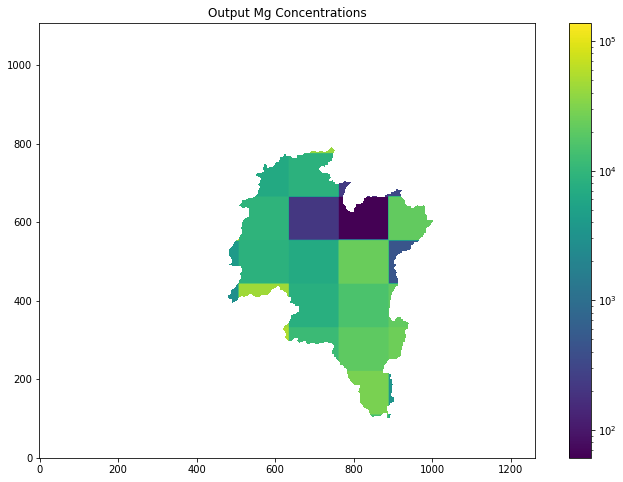

In [21]:

nx=10 #  # <<<<<<<<<<<<<<<<   Change number of x blocks in inversion grid
ny=10 #  # <<<<<<<<<<<<<<<<   Change number of y blocks in inversion grid
lamda=-0.3 # <<<<<<<<<<<<<<<<   Change smoothing coefficient 
elem='Mg' # <<<<<<<<<<<<<<<<  Change element being inverted

### Initiating inversion ####

blocks,active_blocks,block_width,block_height = initiate_blocky_inversion_smart(nx,ny,elem)
parameters = np.copy(blocks[active_blocks]) # The array we will vary. 

#### Perform inversion ####

start = time.time()
res_nm = sp.optimize.minimize(fun=smoothed_objective,args=(blocks,active_blocks,block_width,block_height,elem,lamda),x0=parameters,method='Powell',
                                  options={'disp':True,'xtol':1e-3,'ftol':1e-3})
end = time.time()

#### Finish ####

print("############ results ############")
print("Runtime = ",end-start,"s")
print(res_nm.success) 
print(res_nm.status)
print(res_nm.message)
print(res_nm.nit)

expanded = expand(np.exp(blocks),block_width,block_height)
expanded[np.invert(active_area.reshape(full_shape))] = 'nan'
plt.imshow(expanded,origin='lower',norm=LogNorm())
plt.colorbar()
plt.title("Output Mg Concentrations")
plt.show()


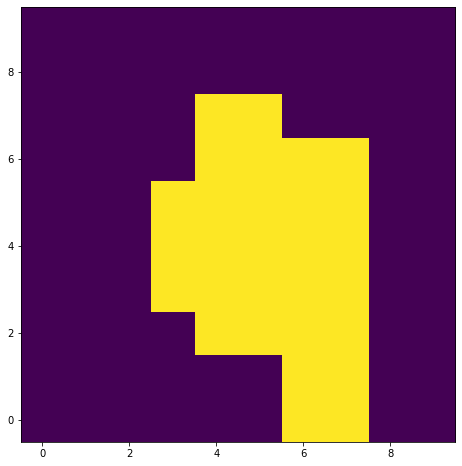

In [22]:
plt.imshow(active_blocks, origin='lower')
plt.show()

In [23]:
nx=84
ny=74

blocks,active_blocks,block_width,block_height = initiate_blocky_inversion_smart(nx,ny,elem)
#saving active blocks in 84x74 raster grid
expanded_active = expand(active_blocks, block_width, block_height)
added_active = mg.add_field('node', 'active_blocks', expanded_active, clobber=True)
mg.save('active_blocks_84x74.asc', names=['active_blocks'])

/home/jonas/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jonas/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
#saving active area at 100x100m resolution:
active_full = mg.add_field('node', 'active_area', active_area, clobber=True)
mg.save('active_area_100m.asc', names=['active_area'])